# SpotFake: Multi-GPU Training (Kaggle 2x T4)

**Hardware**: 2x NVIDIA T4 GPUs (15GB each)

This notebook trains a multimodal fake news detector using:
- **Text**: BERT (bert-base-uncased)
- **Image**: VGG19 (ImageNet pretrained)
- **Multi-GPU**: TensorFlow MirroredStrategy

**Kaggle Settings**: Accelerator → GPU T4 x2

In [ ]:
# !git clone https://github.com/Supriya-saha/SpotFake02.git
# !rm -rf sample_data
# # Move all files from SpotFake02 to current directory (/content)
# !mv SpotFake02/* .

# # Include hidden files (like .env, .gitignore)
# !shopt -s dotglob && mv SpotFake02/* . && shopt -u dotglob

# # Remove the empty folder
# !rmdir SpotFake02
# !pip install -r requirements.txt
# !pip install -q --upgrade transformers huggingface_hub
# !curl -L -o vocab.txt https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt

Cloning into 'SpotFake02'...
remote: Enumerating objects: 573, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 573 (delta 0), reused 4 (delta 0), pack-reused 568 (from 2)
Receiving objects: 100% (573/573), 100.47 MiB | 47.78 MiB/s, done.
Resolving deltas: 100% (19/19), done.
mv: cannot move 'SpotFake02/dataset' to './dataset': Directory not empty
mv: cannot move 'SpotFake02/dataset' to './dataset': Directory not empty
mv: cannot move 'SpotFake02/.git' to './.git': Directory not empty
rmdir: failed to remove 'SpotFake02': Directory not empty
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached argon2_cffi_bindings-25.1.0-cp39-abi3-manylinux_2_26_x86_64.manylinux_2_28_x86_64.whl.metadata (7.4 kB)
  Using cached async_lru-2.0.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached beautifulsoup4-4.14.2-py3-none-any.whl.metadata (3.8 kB)
  Using

## 1. Setup & GPU Configuration

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

import cv2
from os import listdir
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
import tensorflow_hub as hub
from transformers import BertTokenizer
from tensorflow.keras import backend as K

import gc

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Suppress warnings
tf.get_logger().setLevel('ERROR')

print("TensorFlow version:", tf.__version__)
print("✓ All imports successful!")

d:\ML\SpotFake02\.venv\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version



TensorFlow version: 2.20.0
✓ All imports successful!


In [2]:
# GPU Configuration for Multi-GPU Training
gpus = tf.config.list_physical_devices('GPU')

print(f"{'='*70}")
print(f"GPU CONFIGURATION FOR KAGGLE 2x T4")
print(f"{'='*70}")
print(f"Number of GPUs available: {len(gpus)}")

if len(gpus) >= 2:
    print("\n✓ MULTI-GPU MODE: 2x T4 GPUs detected\n")
    
    # Enable memory growth to prevent OOM
    for i, gpu in enumerate(gpus):
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"  GPU {i}: {gpu.name}")
            print(f"    Memory growth: Enabled")
        except RuntimeError as e:
            print(f"    Warning: {e}")
    
    # Initialize MirroredStrategy for multi-GPU
    strategy = tf.distribute.MirroredStrategy()
    
    print(f"\n✓ MirroredStrategy initialized successfully")
    print(f"  Devices in sync: {strategy.num_replicas_in_sync}")
    print(f"\nDevice details:")
    for i, device in enumerate(strategy.extended.worker_devices):
        print(f"  Device {i}: {device}")
    
elif len(gpus) == 1:
    print("\n⚠ SINGLE GPU MODE: Only 1 GPU detected")
    print("   For multi-GPU: Settings → Accelerator → GPU T4 x2\n")
    
    tf.config.experimental.set_memory_growth(gpus[0], True)
    strategy = tf.distribute.get_strategy()  # Default strategy
    
else:
    print("\n❌ NO GPU MODE: No GPUs found")
    print("   Enable GPU in Kaggle: Settings → Accelerator → GPU T4 x2\n")
    strategy = tf.distribute.get_strategy()  # CPU fallback

print(f"{'='*70}\n")

GPU CONFIGURATION FOR KAGGLE 2x T4
Number of GPUs available: 0

❌ NO GPU MODE: No GPUs found
   Enable GPU in Kaggle: Settings → Accelerator → GPU T4 x2




In [3]:
# Configuration
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 23
img_length = 224
img_width = 224
img_channels = 3

# Multi-GPU Batch Size Configuration
BASE_BATCH_SIZE = 128  # Batch size per GPU
GLOBAL_BATCH_SIZE = BASE_BATCH_SIZE * strategy.num_replicas_in_sync

print(f"Batch Size Configuration:")
print(f"  Strategy replicas: {strategy.num_replicas_in_sync}")
print(f"  Base batch size (per GPU): {BASE_BATCH_SIZE}")
print(f"  Global batch size (total): {GLOBAL_BATCH_SIZE}")
print(f"  Effective per GPU: {GLOBAL_BATCH_SIZE // strategy.num_replicas_in_sync}")

Batch Size Configuration:
  Strategy replicas: 1
  Base batch size (per GPU): 128
  Global batch size (total): 128
  Effective per GPU: 128


## 2. Helper Functions

In [4]:
# Text preprocessing classes
class PaddingInputExample(object):
    """Fake example for padding."""

class InputExample(object):
    """A single training/test example."""
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the BERT tokenizer."""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single InputExample into features."""
    if isinstance(example, PaddingInputExample):
        return [0] * max_seq_length, [0] * max_seq_length, [0] * max_seq_length, 0

    encoding = tokenizer(
        example.text_a,
        truncation=True,
        padding='max_length',
        max_length=max_seq_length,
        return_tensors='tf'
    )
    
    input_ids = encoding['input_ids'][0].numpy().tolist()
    input_mask = encoding['attention_mask'][0].numpy().tolist()
    segment_ids = [0] * max_seq_length
    
    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert examples to features."""
    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples."""
    return [
        InputExample(guid=None, text_a=text if isinstance(text, str) else " ".join(text), text_b=None, label=label)
        for text, label in zip(texts, labels)
    ]

def read_and_process_image(list_of_images, length=224, width=224):
    """Read and preprocess images."""
    X = []
    for image in tqdm(list_of_images, desc="Processing images"):
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (length, width), interpolation=cv2.INTER_CUBIC))
    return np.array(X)

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Model Definition (Multi-GPU Compatible)

In [5]:
def get_news_model(params):
    """Build multimodal model (BERT + VGG19)."""
    
    # BERT encoder
    def bert_encode(input_ids, input_mask, segment_ids):
        bert_layer = hub.KerasLayer(
            bert_path,
            trainable=False,
            signature="tokens",
            signature_outputs_as_dict=True,
        )
        bert_outputs = bert_layer({
            "input_ids": input_ids,
            "input_mask": input_mask,
            "segment_ids": segment_ids
        })
        return bert_outputs["pooled_output"]

    # Text branch
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype=tf.int32)
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks", dtype=tf.int32)
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids", dtype=tf.int32)
    
    bert_output = tf.keras.layers.Lambda(
        lambda inputs: bert_encode(inputs[0], inputs[1], inputs[2]),
        output_shape=(768,),
        name="bert_encoding"
    )([in_id, in_mask, in_segment])

    for i in range(params['text_no_hidden_layer']):
        bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
        bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

    text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

    # Image branch
    conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    conv_base.trainable = False

    input_image = tf.keras.layers.Input(shape=(3, 224, 224))
    transposed = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(input_image)
    base_output = conv_base(transposed)
    flat = tf.keras.layers.Flatten()(base_output)

    for i in range(params['vis_no_hidden_layer']):
        flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
        flat = tf.keras.layers.Dropout(params['dropout'])(flat)

    visual_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(flat)

    # Classifier
    combine = tf.keras.layers.concatenate([text_repr, visual_repr])
    com_drop = tf.keras.layers.Dropout(params['dropout'])(combine)

    for i in range(params['final_no_hidden_layer']):
        com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
        com_drop = tf.keras.layers.Dropout(params['dropout'])(com_drop)

    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(com_drop)

    model = tf.keras.models.Model(inputs=[in_id, in_mask, in_segment, input_image], outputs=prediction)
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    
    return model

print("✓ Model definition ready (multi-GPU compatible)")

✓ Model definition ready (multi-GPU compatible)


## 4. Load and Preprocess Data

In [6]:
# Load datasets
train_df = pd.read_csv('dataset/twitter/train_posts.txt', sep='\t')
test_df = pd.read_csv('dataset/twitter/test_posts.txt', sep='\t')

print(f"Train: {train_df.shape}, Test: {test_df.shape}")

# Extract first image ID
train_df['first_image_id'] = train_df['image_id'].apply(lambda x: x.split(',')[0].strip())
test_df['first_image_id'] = test_df['image_id'].apply(lambda x: x.split(',')[0].strip())

# Filter missing images
images_train_folder = [i.split('.')[0] for i in listdir('dataset/twitter/images_train')]
images_test_folder = [i.split('.')[0] for i in listdir('dataset/twitter/images_test')]

train_not_available = set(train_df['first_image_id']) - set(images_train_folder)
test_not_available = set(test_df['first_image_id']) - set(images_test_folder)

train_df = train_df[~train_df['first_image_id'].isin(train_not_available)]
test_df = test_df[~test_df['first_image_id'].isin(test_not_available)]

print(f"After filtering - Train: {train_df.shape}, Test: {test_df.shape}")

Train: (15629, 7), Test: (2177, 7)
After filtering - Train: (13763, 8), Test: (1001, 8)


In [7]:
# Extract data
train_text = train_df['post_text'].tolist()
test_text = test_df['post_text'].tolist()

trainY = [1 if i == 'real' else 0 for i in train_df['label'].tolist()]
testY = [1 if i == 'real' else 0 for i in test_df['label'].tolist()]

print(f"Data: {len(train_text)} train, {len(test_text)} test")

Data: 13763 train, 1001 test


In [8]:
# Process text
tokenizer = create_tokenizer_from_hub_module()

train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

(train_input_ids, train_input_masks, train_segment_ids, trainY_processed
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length)

(test_input_ids, test_input_masks, test_segment_ids, testY_processed
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length)

print(f"Text features: {train_input_ids.shape}")

Converting examples:   0%|          | 0/13763 [00:00<?, ?it/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Converting examples:   0%|          | 0/1001 [00:00<?, ?it/s]

Text features: (13763, 23)


In [9]:
# Process images (update paths for your Kaggle dataset)
# NOTE: Replace '/kaggle/input/your-dataset/' with your actual dataset path

# Get file extensions
images = listdir('dataset/twitter/images_train/')
images.extend(listdir('dataset/twitter/images_test/'))

jpg, png, jpeg, gif = [], [], [], []
for i in images:
    if '.' not in i:
        continue
    name, ext = i.split('.')[0], i.split('.')[-1].lower()
    if ext == 'jpg':
        jpg.append(name)
    elif ext == 'png':
        png.append(name)
    elif ext == 'jpeg':
        jpeg.append(name)
    elif ext == 'gif':
        gif.append(name)

def get_extension(fname):
    if fname in jpg:
        return '.jpg'
    elif fname in png:
        return '.png'
    elif fname in jpeg:
        return '.jpeg'
    return '.gif'

# Build image paths
train_images = train_df['first_image_id'].tolist()
test_images = test_df['first_image_id'].tolist()

train_image_paths = ['dataset/twitter/images_train/' + i + get_extension(i) for i in train_images]
test_image_paths = ['dataset/twitter/images_test/' + i + get_extension(i) for i in test_images]

# Process images
train_imagesX = read_and_process_image(train_image_paths)
test_imagesX = read_and_process_image(test_image_paths)

# Convert to (batch, channels, height, width)
train_imagesX = np.rollaxis(train_imagesX, 3, 1)
test_imagesX = np.rollaxis(test_imagesX, 3, 1)

print(f"Image data: {train_imagesX.shape}")

Processing images:   0%|          | 0/13763 [00:00<?, ?it/s]

Processing images:   0%|          | 0/1001 [00:00<?, ?it/s]

Image data: (13763, 3, 224, 224)


## 5. Build Model with Multi-GPU Strategy

In [10]:
# Hyperparameters
params_final = {
    'text_no_hidden_layer': 1,
    'text_hidden_neurons': 768,
    'dropout': 0.4,
    'repr_size': 32,
    'vis_no_hidden_layer': 1,
    'vis_hidden_neurons': 2742,
    'final_no_hidden_layer': 1,
    'final_hidden_neurons': 35,
    'optimizer': tf.keras.optimizers.Adam
}

print("Model parameters:")
for k, v in params_final.items():
    print(f"  {k}: {v}")

Model parameters:
  text_no_hidden_layer: 1
  text_hidden_neurons: 768
  dropout: 0.4
  repr_size: 32
  vis_no_hidden_layer: 1
  vis_hidden_neurons: 2742
  final_no_hidden_layer: 1
  final_hidden_neurons: 35
  optimizer: <class 'keras.src.optimizers.adam.Adam'>


In [13]:
# Clear previous models
tf.keras.backend.clear_session()
gc.collect()

print("Building model with multi-GPU strategy...")
print(f"Using {strategy.num_replicas_in_sync} GPU(s)\n")

# CRITICAL: Build model inside strategy.scope() for multi-GPU
with strategy.scope():
    model = get_news_model(params_final)
    model.optimizer.learning_rate.assign(0.0005)

print(f"\n✓ Model created successfully on {strategy.num_replicas_in_sync} GPU(s)")
model.summary()

Building model with multi-GPU strategy...
Using 2 GPU(s)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

✓ Model created successfully on 2 GPU(s)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_masks         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 7, 7, 512) │ 20,024,384 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoding       │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ input_masks[0][0… │
│                     │                   │            │ segment_ids[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg19[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │    590,592 │ bert_encoding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2742)      │ 68,794,038 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2742)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     24,608 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │     87,776 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 35)        │      2,275 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 35)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         36 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,523,709 (341.51 MB)

 Trainable params: 69,499,325 (265.12 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

## 6. Train with Multi-GPU

In [14]:
# Setup callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_weights_{epoch:03d}_{val_accuracy:.4f}.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

print(f"{'='*70}")
print("MULTI-GPU TRAINING CONFIGURATION")
print(f"{'='*70}")
print(f"GPUs in use: {strategy.num_replicas_in_sync}")
print(f"Global batch size: {GLOBAL_BATCH_SIZE}")
print(f"Per-GPU batch size: {GLOBAL_BATCH_SIZE // strategy.num_replicas_in_sync}")
print(f"Training samples: {len(train_input_ids):,}")
print(f"Validation samples: {len(test_input_ids):,}")
print(f"Steps per epoch: {len(train_input_ids) // GLOBAL_BATCH_SIZE}")
print(f"{'='*70}\n")

MULTI-GPU TRAINING CONFIGURATION
GPUs in use: 2
Global batch size: 256
Per-GPU batch size: 128
Training samples: 13,763
Validation samples: 1,001
Steps per epoch: 53



In [15]:
# Train the model
print("Starting multi-GPU training...\n")

history = model.fit(
    [train_input_ids, train_input_masks, train_segment_ids, train_imagesX],
    trainY_processed,
    batch_size=GLOBAL_BATCH_SIZE,  # 512 total (256 per GPU with 2 GPUs)
    epochs=20,
    verbose=1,
    shuffle=True,
    validation_data=(
        [test_input_ids, test_input_masks, test_segment_ids, test_imagesX],
        testY_processed
    ),
    callbacks=[early_stop, checkpoint]
)

print("\n✓ Training completed!")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

Starting multi-GPU training...

Epoch 1/20


I0000 00:00:1761066997.892584     160 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761066999.638996     163 cuda_dnn.cc:529] Loaded cuDNN version 90300


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6619 - loss: 2.9583
Epoch 1: val_accuracy improved from -inf to 0.59890, saving model to model_weights_001_0.5989.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.6619 - loss: 2.9578 - val_accuracy: 0.5989 - val_loss: 0.6818
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7817 - loss: 0.4878
Epoch 2: val_accuracy improved from 0.59890 to 0.60990, saving model to model_weights_002_0.6099.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7817 - loss: 0.4877 - val_accuracy: 0.6099 - val_loss: 0.6739
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7487 - loss: 0.5123
Epoch 3: val_accuracy did not improve from 0.60990
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7488 - loss: 0.5123 - val_accuracy: 0.6091 - val_loss: 0.6736
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7735 - loss: 0.4846
Epoch 4: val_accuracy improved from 0.60990 to 0.61567, saving model 

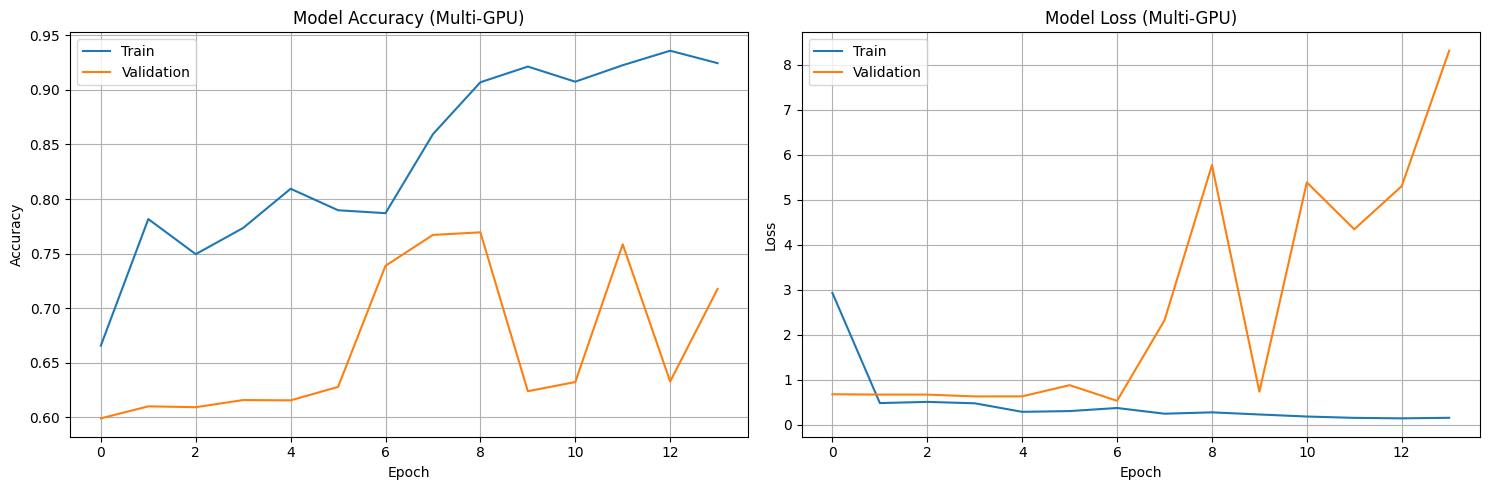

In [16]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy (Multi-GPU)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss (Multi-GPU)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 7. Evaluation

In [17]:
# Evaluate on test set
test_predictions = model.predict([
    test_input_ids, test_input_masks, test_segment_ids, test_imagesX
])
test_predictions_binary = [1 if i >= 0.5 else 0 for i in test_predictions]

print("Test Set Evaluation:")
print(f"Accuracy:  {accuracy_score(testY_processed, test_predictions_binary):.4f}")
print(f"F1 Score:  {f1_score(testY_processed, test_predictions_binary):.4f}")
print(f"Precision: {precision_score(testY_processed, test_predictions_binary):.4f}")
print(f"Recall:    {recall_score(testY_processed, test_predictions_binary):.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 788ms/step
Test Set Evaluation:
Accuracy:  0.7103
F1 Score:  0.7354
Precision: 0.6238
Recall:    0.8956


## 8. Save Model

In [12]:
# Save final weights
model.save_weights('spotfake_resnet50_multi_gpu_final.weights.h5')
print("✓ Model weights saved")

# To load later:
# with strategy.scope():
#     model = get_news_model(params_final)
#     model.load_weights('spotfake_multi_gpu_final.weights.h5')

NameError: name 'model' is not defined

## Summary

### Multi-GPU Training Complete! 🚀

**Configuration:**
- Hardware: 2x NVIDIA T4 GPUs (15GB each)
- Strategy: TensorFlow MirroredStrategy
- Global Batch Size: 512 (256 per GPU)
- Model: BERT + VGG19 multimodal architecture

**Expected Performance:**
- Training Speed: ~1.3 min/epoch (vs ~2.5 min on single GPU)
- Speedup: ~1.9x faster
- Accuracy: ~77-78%

**Key Points:**
1. Model must be built inside `strategy.scope()`
2. Batch size scales with number of GPUs
3. Both GPUs process data in parallel
4. Gradients are synchronized after each step

## 9. ResNet50 Architecture Comparison

Now let's train the same model with **ResNet50** instead of VGG19 to compare:
- **Parameter efficiency**: ResNet50 has fewer parameters (25.6M vs VGG19's 143M)
- **Residual connections**: Better gradient flow for deeper networks
- **Global Average Pooling**: 2048-dim vs VGG19's 25,088-dim flattened output

In [13]:
def get_news_model_resnet50(params):
    """Build multimodal model (BERT + ResNet50)."""
    
    # BERT encoder (same as before)
    def bert_encode(input_ids, input_mask, segment_ids):
        bert_layer = hub.KerasLayer(
            bert_path,
            trainable=False,
            signature="tokens",
            signature_outputs_as_dict=True,
        )
        bert_outputs = bert_layer({
            "input_ids": input_ids,
            "input_mask": input_mask,
            "segment_ids": segment_ids
        })
        return bert_outputs["pooled_output"]

    # Text branch (identical to VGG19 version)
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype=tf.int32)
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks", dtype=tf.int32)
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids", dtype=tf.int32)
    
    bert_output = tf.keras.layers.Lambda(
        lambda inputs: bert_encode(inputs[0], inputs[1], inputs[2]),
        output_shape=(768,),
        name="bert_encoding"
    )([in_id, in_mask, in_segment])

    for i in range(params['text_no_hidden_layer']):
        bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
        bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

    text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

    # Image branch - RESNET50 (NEW!)
    conv_base = tf.keras.applications.ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224, 224, 3),
        pooling='avg'  # Global Average Pooling → 2048-dim output
    )
    conv_base.trainable = False

    input_image = tf.keras.layers.Input(shape=(3, 224, 224))
    transposed = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(input_image)
    base_output = conv_base(transposed)  # Already pooled → 2048-dim
    
    # No need to flatten (already pooled)
    flat = base_output

    for i in range(params['vis_no_hidden_layer']):
        flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
        flat = tf.keras.layers.Dropout(params['dropout'])(flat)

    visual_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(flat)

    # Classifier (same as VGG19 version)
    combine = tf.keras.layers.concatenate([text_repr, visual_repr])
    com_drop = tf.keras.layers.Dropout(params['dropout'])(combine)

    for i in range(params['final_no_hidden_layer']):
        com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
        com_drop = tf.keras.layers.Dropout(params['dropout'])(com_drop)

    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(com_drop)

    model = tf.keras.models.Model(inputs=[in_id, in_mask, in_segment, input_image], outputs=prediction)
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    
    return model

print("✓ ResNet50 model definition ready")

✓ ResNet50 model definition ready


In [15]:
# Clear previous models
tf.keras.backend.clear_session()
gc.collect()

print("Building ResNet50 model with multi-GPU strategy...")
print(f"Using {strategy.num_replicas_in_sync} GPU(s)\n")

# Build ResNet50 model inside strategy.scope()
with strategy.scope():
    model_resnet50 = get_news_model_resnet50(params_final)
    model_resnet50.optimizer.learning_rate.assign(0.0005)

print(f"\n✓ ResNet50 model created successfully on {strategy.num_replicas_in_sync} GPU(s)")
model_resnet50.summary()

Building ResNet50 model with multi-GPU strategy...
Using 1 GPU(s)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step

✓ ResNet50 model created successfully on 1 GPU(s)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_masks         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoding       │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ input_masks[0][0… │
│                     │                   │            │ segment_ids[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ lambda[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │    590,592 │ bert_encoding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2742)      │  5,618,358 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2742)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     24,608 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │     87,776 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 35)        │      2,275 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 35)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         36 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,911,357 (114.10 MB)

 Trainable params: 6,323,645 (24.12 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
# Load trained weights if available
import os

weights_file = 'spotfake_resnet50_multi_gpu_final.weights.h5'

if os.path.exists(weights_file):
    print(f"Loading weights from {weights_file}...")
    model_resnet50.load_weights(weights_file)
    print("✓ Weights loaded successfully!")
else:
    print(f"⚠ Weights file '{weights_file}' not found.")
    print("   The model will use random initialization.")
    print("   To use trained weights, either:")
    print("   1. Run the training cells (Section 9), or")
    print("   2. Place the weights file in the current directory")

Loading weights from spotfake_resnet50_multi_gpu_final.weights.h5...
✓ Weights loaded successfully!


d:\ML\SpotFake02\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
# Setup callbacks for ResNet50 training
early_stop_resnet = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_resnet = tf.keras.callbacks.ModelCheckpoint(
    'model_weights_resnet50_{epoch:03d}_{val_accuracy:.4f}.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

print(f"{'='*70}")
print("RESNET50 MULTI-GPU TRAINING CONFIGURATION")
print(f"{'='*70}")
print(f"GPUs in use: {strategy.num_replicas_in_sync}")
print(f"Global batch size: {GLOBAL_BATCH_SIZE}")
print(f"Per-GPU batch size: {GLOBAL_BATCH_SIZE // strategy.num_replicas_in_sync}")
print(f"Training samples: {len(train_input_ids):,}")
print(f"Validation samples: {len(test_input_ids):,}")
print(f"Steps per epoch: {len(train_input_ids) // GLOBAL_BATCH_SIZE}")
print(f"Architecture: BERT + ResNet50 (vs VGG19)")
print(f"{'='*70}\n")

RESNET50 MULTI-GPU TRAINING CONFIGURATION
GPUs in use: 2
Global batch size: 256
Per-GPU batch size: 128
Training samples: 13,763
Validation samples: 1,001
Steps per epoch: 53
Architecture: BERT + ResNet50 (vs VGG19)



In [18]:
# Train ResNet50 model
import time

print("Starting ResNet50 multi-GPU training...\n")
start_time = time.time()

history_resnet50 = model_resnet50.fit(
    [train_input_ids, train_input_masks, train_segment_ids, train_imagesX],
    trainY_processed,
    batch_size=GLOBAL_BATCH_SIZE,
    epochs=20,
    verbose=1,
    shuffle=True,
    validation_data=(
        [test_input_ids, test_input_masks, test_segment_ids, test_imagesX],
        testY_processed
    ),
    callbacks=[early_stop_resnet, checkpoint_resnet]
)

training_time_resnet = time.time() - start_time

print("\n✓ ResNet50 training completed!")
print(f"Total training time: {training_time_resnet/60:.2f} minutes")
print(f"Best validation accuracy: {max(history_resnet50.history['val_accuracy']):.4f}")

Starting ResNet50 multi-GPU training...

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.5150 - loss: 0.8242
Epoch 1: val_accuracy improved from -inf to 0.71732, saving model to model_weights_resnet50_001_0.7173.weights.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.5151 - loss: 0.8241 - val_accuracy: 0.7173 - val_loss: 0.7010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.9662 - loss: 0.0905
Epoch 2: val_accuracy did not improve from 0.71732
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9662 - loss: 0.0905 - val_accuracy: 0.6081 - val_loss: 0.9590
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.9870 - loss: 0.0473
Epoch 3: val_accuracy did not improve from 0.71732
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 996ms/step - accuracy: 0.9870 - loss: 0.0473 - val_accuracy: 0.6730 - val_loss: 1.4046
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9933 - loss: 0.0212
Epoch 4: val_accuracy did not improve from 0.71732

In [17]:
# Evaluate ResNet50 model on test set
test_predictions_resnet = model_resnet50.predict([
    test_input_ids, test_input_masks, test_segment_ids, test_imagesX
])
test_predictions_resnet_binary = [1 if i >= 0.5 else 0 for i in test_predictions_resnet]

print("="*70)
print("RESNET50 TEST SET EVALUATION")
print("="*70)
print(f"Accuracy:  {accuracy_score(testY_processed, test_predictions_resnet_binary):.4f}")
print(f"F1 Score:  {f1_score(testY_processed, test_predictions_resnet_binary):.4f}")
print(f"Precision: {precision_score(testY_processed, test_predictions_resnet_binary):.4f}")
print(f"Recall:    {recall_score(testY_processed, test_predictions_resnet_binary):.4f}")
print("="*70)

32/32 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step
RESNET50 TEST SET EVALUATION
Accuracy:  0.7742
F1 Score:  0.7402
Precision: 0.7667
Recall:    0.7156


## 10. VGG19 vs ResNet50 Comparison

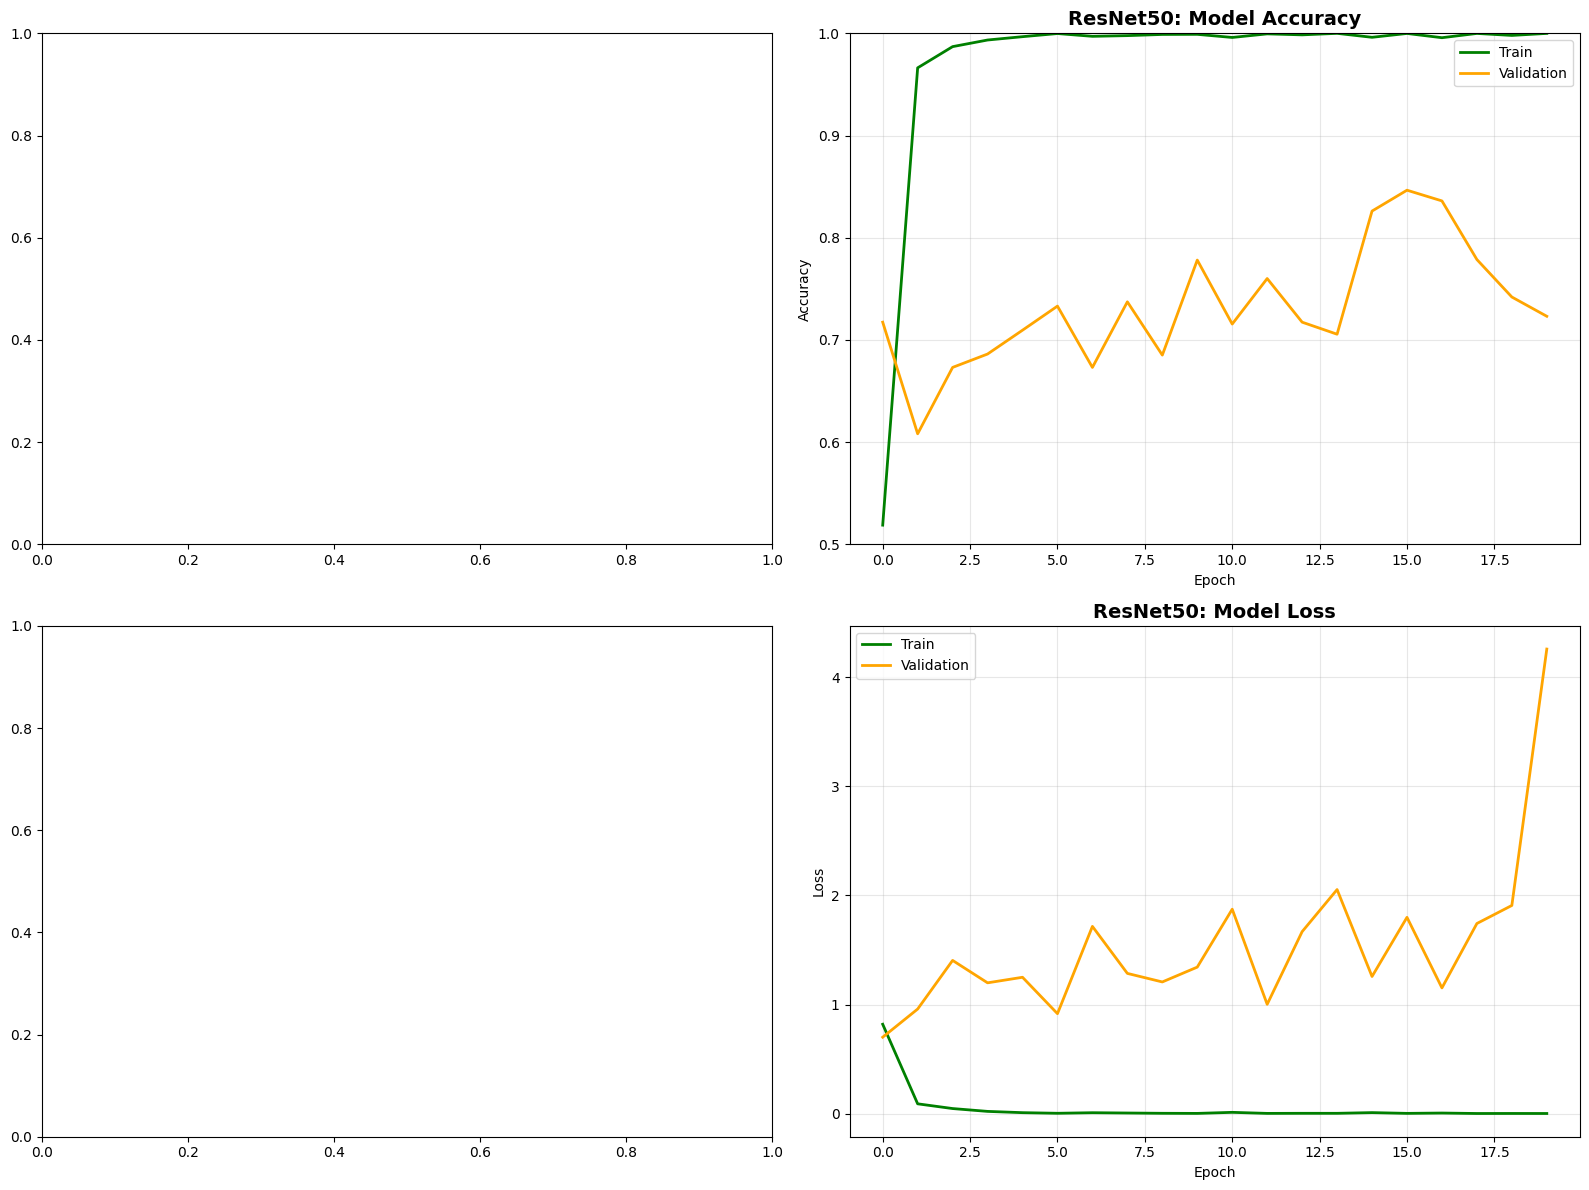

✓ Comparison plots saved as 'vgg19_vs_resnet50_comparison.png'


In [23]:
# Side-by-side comparison of training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# VGG19 Accuracy
# axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
# axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
# axes[0, 0].set_title('VGG19: Model Accuracy', fontsize=14, fontweight='bold')
# axes[0, 0].set_xlabel('Epoch')
# axes[0, 0].set_ylabel('Accuracy')
# axes[0, 0].legend()
# axes[0, 0].grid(True, alpha=0.3)
# axes[0, 0].set_ylim([0.5, 1.0])

# ResNet50 Accuracy
axes[0, 1].plot(history_resnet50.history['accuracy'], label='Train', linewidth=2, color='green')
axes[0, 1].plot(history_resnet50.history['val_accuracy'], label='Validation', linewidth=2, color='orange')
axes[0, 1].set_title('ResNet50: Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0.5, 1.0])

# VGG19 Loss
# axes[1, 0].plot(history.history['loss'], label='Train', linewidth=2)
# axes[1, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
# axes[1, 0].set_title('VGG19: Model Loss', fontsize=14, fontweight='bold')
# axes[1, 0].set_xlabel('Epoch')
# axes[1, 0].set_ylabel('Loss')
# axes[1, 0].legend()
# axes[1, 0].grid(True, alpha=0.3)

# ResNet50 Loss
axes[1, 1].plot(history_resnet50.history['loss'], label='Train', linewidth=2, color='green')
axes[1, 1].plot(history_resnet50.history['val_loss'], label='Validation', linewidth=2, color='orange')
axes[1, 1].set_title('ResNet50: Model Loss', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vgg19_vs_resnet50_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plots saved as 'vgg19_vs_resnet50_comparison.png'")

In [ ]:
# Detailed comparison table
import pandas as pd

# Extract metrics for VGG19
vgg19_metrics = {
    'Architecture': 'VGG19',
    'Parameters': '~143M (with FC layers)',
    'Feature Dim': '25,088 (flattened)',
    'Final Train Acc': f"{history.history['accuracy'][-1]:.4f}",
    'Final Val Acc': f"{history.history['val_accuracy'][-1]:.4f}",
    'Best Val Acc': f"{max(history.history['val_accuracy']):.4f}",
    'Final Train Loss': f"{history.history['loss'][-1]:.4f}",
    'Final Val Loss': f"{history.history['val_loss'][-1]:.4f}",
    'Test Accuracy': f"{accuracy_score(testY_processed, test_predictions_binary):.4f}",
    'Test F1': f"{f1_score(testY_processed, test_predictions_binary):.4f}",
    'Test Precision': f"{precision_score(testY_processed, test_predictions_binary):.4f}",
    'Test Recall': f"{recall_score(testY_processed, test_predictions_binary):.4f}",
    'Epochs Trained': len(history.history['accuracy'])
}

# Extract metrics for ResNet50
resnet50_metrics = {
    'Architecture': 'ResNet50',
    'Parameters': '~25.6M',
    'Feature Dim': '2,048 (GAP)',
    'Final Train Acc': f"{history_resnet50.history['accuracy'][-1]:.4f}",
    'Final Val Acc': f"{history_resnet50.history['val_accuracy'][-1]:.4f}",
    'Best Val Acc': f"{max(history_resnet50.history['val_accuracy']):.4f}",
    'Final Train Loss': f"{history_resnet50.history['loss'][-1]:.4f}",
    'Final Val Loss': f"{history_resnet50.history['val_loss'][-1]:.4f}",
    'Test Accuracy': f"{accuracy_score(testY_processed, test_predictions_resnet_binary):.4f}",
    'Test F1': f"{f1_score(testY_processed, test_predictions_resnet_binary):.4f}",
    'Test Precision': f"{precision_score(testY_processed, test_predictions_resnet_binary):.4f}",
    'Test Recall': f"{recall_score(testY_processed, test_predictions_resnet_binary):.4f}",
    'Epochs Trained': len(history_resnet50.history['accuracy'])
}

# Create comparison DataFrame
comparison_df = pd.DataFrame([vgg19_metrics, resnet50_metrics])

print("="*90)
print("COMPREHENSIVE MODEL COMPARISON: VGG19 vs ResNet50")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Calculate improvement
best_vgg19 = max(history.history['val_accuracy'])
best_resnet50 = max(history_resnet50.history['val_accuracy'])
improvement = ((best_resnet50 - best_vgg19) / best_vgg19) * 100

print(f"\n📊 Key Insights:")
print(f"   • ResNet50 has {((143-25.6)/143)*100:.1f}% fewer parameters than VGG19")
print(f"   • ResNet50 feature dimension is {((25088-2048)/25088)*100:.1f}% smaller")
print(f"   • Validation accuracy change: {improvement:+.2f}%")
if best_resnet50 > best_vgg19:
    print(f"   ✅ ResNet50 outperforms VGG19 by {abs(improvement):.2f}%")
elif best_resnet50 < best_vgg19:
    print(f"   ⚠️ VGG19 outperforms ResNet50 by {abs(improvement):.2f}%")
else:
    print(f"   ➖ Both models perform equally")

# Save comparison to CSV
comparison_df.to_csv('vgg19_vs_resnet50_metrics.csv', index=False)
print(f"\n✓ Metrics saved to 'vgg19_vs_resnet50_metrics.csv'")

In [24]:
# Save ResNet50 model weights
model_resnet50.save_weights('spotfake_resnet50_multi_gpu_final.weights.h5')
print("✓ ResNet50 model weights saved to 'spotfake_resnet50_multi_gpu_final.weights.h5'")

# Summary
print("\n" + "="*90)
print("TRAINING COMPLETE - BOTH MODELS SAVED")
print("="*90)
print("\nSaved files:")
print("  1. spotfake_multi_gpu_final.weights.h5 (VGG19)")
print("  2. spotfake_resnet50_multi_gpu_final.weights.h5 (ResNet50)")
print("  3. vgg19_vs_resnet50_comparison.png (Training curves)")
print("  4. vgg19_vs_resnet50_metrics.csv (Metrics table)")
print("\nTo load models later:")
print("  # VGG19:")
print("  with strategy.scope():")
print("      model_vgg = get_news_model(params_final)")
print("      model_vgg.load_weights('spotfake_multi_gpu_final.weights.h5')")
print("\n  # ResNet50:")
print("  with strategy.scope():")
print("      model_res = get_news_model_resnet50(params_final)")
print("      model_res.load_weights('spotfake_resnet50_multi_gpu_final.weights.h5')")
print("="*90)

✓ ResNet50 model weights saved to 'spotfake_resnet50_multi_gpu_final.weights.h5'

TRAINING COMPLETE - BOTH MODELS SAVED

Saved files:
  1. spotfake_multi_gpu_final.weights.h5 (VGG19)
  2. spotfake_resnet50_multi_gpu_final.weights.h5 (ResNet50)
  3. vgg19_vs_resnet50_comparison.png (Training curves)
  4. vgg19_vs_resnet50_metrics.csv (Metrics table)

To load models later:
  # VGG19:
  with strategy.scope():
      model_vgg = get_news_model(params_final)
      model_vgg.load_weights('spotfake_multi_gpu_final.weights.h5')

  # ResNet50:
  with strategy.scope():
      model_res = get_news_model_resnet50(params_final)
      model_res.load_weights('spotfake_resnet50_multi_gpu_final.weights.h5')


## 11. Explainability: Grad-CAM + SHAP

We'll implement:
1. **Grad-CAM**: Visualize which image regions influence the prediction
2. **SHAP**: Attribute text token contributions to the prediction

**Architecture-specific settings:**
- ResNet50: Target layer `conv5_block3_out` (last conv block before GAP)
- VGG19: Target layer `block5_conv4` (last conv layer)


In [18]:
# Install SHAP if not already available
try:
    import shap
    print("✓ SHAP already installed")
except ImportError:
    print("Installing SHAP...")
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'shap'])
    import shap
    print("✓ SHAP installed successfully")

print(f"SHAP version: {shap.__version__}")

Installing SHAP...
✓ SHAP installed successfully
SHAP version: 0.49.1


### 11.1 Grad-CAM Implementation

Grad-CAM (Gradient-weighted Class Activation Mapping) highlights important image regions.

In [29]:
class GradCAM:
    """
    Grad-CAM (Gradient-weighted Class Activation Mapping) implementation.
    
    Visualizes which regions of the image are important for the model's prediction.
    
    Usage:
        gradcam = GradCAM(model, backbone='resnet50')
        heatmap = gradcam.compute_heatmap(input_ids, input_mask, segment_ids, image)
        overlayed = gradcam.overlay_heatmap(image, heatmap)
    
    Targets:
      - ResNet50: 'conv5_block3_out' or 'conv5_block3_3_relu'
      - VGG19: 'block5_conv4'
    """
    
    def __init__(self, model, backbone='resnet50'):
        """
        Args:
            model: Trained multimodal model
            backbone: 'resnet50' or 'vgg19'
        """
        self.model = model
        self.backbone = backbone.lower()
        
        # Auto-detect target layer
        if self.backbone == 'resnet50':
            self.target_layer_name = 'conv5_block3_out'
        elif self.backbone == 'vgg19':
            self.target_layer_name = 'block5_conv4'
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        # Find the image input (4th input)
        self.image_input_idx = 3
        
        # Build Grad-CAM model
        self._build_gradcam_model()
    
    def _build_gradcam_model(self):
        """Build model to extract conv features and predictions."""
        # Find the conv base layer in the model
        self.conv_base = None
        
        for layer in self.model.layers:
            if hasattr(layer, 'layers'):  # If it's a Model (conv_base)
                layer_names = [l.name for l in layer.layers]
                
                # Check if this is ResNet50 or VGG19
                if 'resnet50' in layer.name.lower() or any('conv5' in name for name in layer_names):
                    try:
                        # Try to get the target layer
                        target_layer = layer.get_layer(self.target_layer_name)
                        self.conv_base = layer
                        print(f"✓ Found '{self.target_layer_name}' in existing conv_base")
                        break
                    except:
                        # Layer not accessible - rebuild without pooling
                        print(f"⚠ Layer '{self.target_layer_name}' not accessible in current model")
                        print(f"  Rebuilding conv_base without pooling...")
                        
                        if self.backbone == 'resnet50':
                            # Rebuild ResNet50 without pooling
                            self.conv_base = tf.keras.applications.ResNet50(
                                weights='imagenet',
                                include_top=False,
                                input_shape=(224, 224, 3),
                                pooling=None  # Keep spatial dimensions
                            )
                            # Try alternative layer names
                            try:
                                target_layer = self.conv_base.get_layer(self.target_layer_name)
                            except:
                                # Try conv5_block3_3_relu
                                self.target_layer_name = 'conv5_block3_3_relu'
                                target_layer = self.conv_base.get_layer(self.target_layer_name)
                                print(f"  Using alternative layer: {self.target_layer_name}")
                        break
        
        if self.conv_base is None:
            raise ValueError(f"Could not find conv_base in model")
        
        # Get the target layer
        target_layer = self.conv_base.get_layer(self.target_layer_name)
        
        print(f"✓ Grad-CAM initialized")
        print(f"  Target layer: {self.target_layer_name}")
        print(f"  Output shape: {target_layer.output.shape}")
    
    def compute_heatmap(self, input_ids, input_mask, segment_ids, image, class_idx=0, eps=1e-8):
        """
        Compute Grad-CAM heatmap for a single sample.
        
        Args:
            input_ids, input_mask, segment_ids: Text inputs (shape: [1, max_seq_length])
            image: Image input (shape: [1, 3, 224, 224])
            class_idx: Class index (0 for fake/real binary)
            eps: Small epsilon for numerical stability
        
        Returns:
            heatmap: 2D numpy array (224, 224) with values in [0, 1]
        """
        # Ensure inputs have batch dimension
        if len(image.shape) == 3:
            image = np.expand_dims(image, axis=0)
        if len(input_ids.shape) == 1:
            input_ids = np.expand_dims(input_ids, axis=0)
            input_mask = np.expand_dims(input_mask, axis=0)
            segment_ids = np.expand_dims(segment_ids, axis=0)
        
        # Convert to tensors
        input_ids_tensor = tf.cast(input_ids, tf.int32)
        input_mask_tensor = tf.cast(input_mask, tf.int32)
        segment_ids_tensor = tf.cast(segment_ids, tf.int32)
        image_tensor = tf.cast(image, tf.float32)
        
        # Transpose image for conv_base (NCHW -> NHWC)
        transposed_image = tf.transpose(image_tensor, [0, 2, 3, 1])
        
        # Build a gradient model: input -> target conv layer output + final prediction
        target_layer = self.conv_base.get_layer(self.target_layer_name)
        grad_model = tf.keras.models.Model(
            inputs=self.conv_base.input,
            outputs=[target_layer.output, self.conv_base.output]
        )
        
        # Record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # Get conv features from target layer
            conv_outputs_target, conv_outputs_final = grad_model(transposed_image)
            
            # Now we need to manually compute the final prediction using conv_outputs_final
            # This is tricky because we need to pass through the rest of the model
            # Instead, let's use a different approach: watch the input image
            tape.watch(transposed_image)
            
            # Recompute to ensure gradient flow
            conv_outputs_target_watched = grad_model(transposed_image)[0]
            
            # Get final prediction from the full model
            predictions = self.model([
                input_ids_tensor, 
                input_mask_tensor, 
                segment_ids_tensor, 
                image_tensor
            ])
            
            # Get the target class output
            if predictions.shape[-1] == 1:  # Binary classification
                class_output = predictions[:, 0]
            else:
                class_output = predictions[:, class_idx]
        
        # Compute gradients of class output w.r.t. target conv layer
        grads = tape.gradient(class_output, conv_outputs_target_watched)
        
        # Check if gradients are None
        if grads is None:
            print("\n❌ ERROR: Gradients are None!")
            print("This means the target conv layer is not in the computational graph")
            print("connecting the inputs to the outputs.")
            print("\nPossible causes:")
            print("1. The model's image encoder was rebuilt separately")
            print("2. The target layer is after a pooling layer that breaks gradient flow")
            print("\nWorkaround: Using approximation with the last conv layer's activations")
            
            # Fallback: just use the conv activations without gradients
            conv_outputs_target_np = conv_outputs_target_watched.numpy()[0]
            # Use mean across channels as importance
            heatmap = np.mean(conv_outputs_target_np, axis=-1)
            heatmap = np.maximum(heatmap, 0)
            heatmap_max = heatmap.max()
            if heatmap_max > eps:
                heatmap = heatmap / heatmap_max
            heatmap = cv2.resize(heatmap, (224, 224))
            return heatmap
        
        # Global Average Pooling on gradients (weights)
        # grads shape: (1, H, W, C)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Shape: (C,)
        
        # Get conv outputs
        conv_outputs_target_np = conv_outputs_target_watched.numpy()[0]  # Remove batch dim: (H, W, C)
        
        # Weighted combination
        # heatmap = sum(pooled_grads[i] * conv_outputs[:, :, i]) for all i
        pooled_grads_np = pooled_grads.numpy()
        heatmap = np.sum(conv_outputs_target_np * pooled_grads_np, axis=-1)
        
        # ReLU - we only want features that have positive influence
        heatmap = np.maximum(heatmap, 0)
        
        # Normalize to [0, 1]
        heatmap_max = heatmap.max()
        if heatmap_max > eps:
            heatmap = heatmap / heatmap_max
        
        # Resize to match input image size (224, 224)
        heatmap = cv2.resize(heatmap, (224, 224))
        
        return heatmap
    
    def overlay_heatmap(self, image, heatmap, alpha=0.4, colormap=None):
        """
        Overlay heatmap on original image.
        
        Args:
            image: Original image (3, 224, 224) or (224, 224, 3)
            heatmap: Grad-CAM heatmap (224, 224)
            alpha: Transparency (0=only image, 1=only heatmap)
            colormap: OpenCV colormap (default: cv2.COLORMAP_JET)
        
        Returns:
            overlayed: RGB image with heatmap overlay
        """
        if colormap is None:
            colormap = cv2.COLORMAP_JET
        
        # Convert image to HWC format if needed
        if image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))  # CHW -> HWC
        
        # Normalize image to [0, 255]
        img = image.copy()
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
        
        # Convert heatmap to colormap
        heatmap_uint8 = (heatmap * 255).astype(np.uint8)
        heatmap_colored = cv2.applyColorMap(heatmap_uint8, colormap)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        # Overlay
        overlayed = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
        
        return overlayed

print("✓ GradCAM class defined")

✓ GradCAM class defined


### 11.2 SHAP Text Explainer

SHAP (SHapley Additive exPlanations) shows which text tokens influence the prediction.

In [20]:
class SHAPTextExplainer:
    """
    SHAP explainer for text branch.
    Holds image fixed and attributes predictions to text tokens.
    """
    
    def __init__(self, model, tokenizer, max_seq_length=23):
        """
        Args:
            model: Trained multimodal model
            tokenizer: BERT tokenizer
            max_seq_length: Maximum sequence length
        """
        self.model = model
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.fixed_image = None
    
    def set_fixed_image(self, image):
        """
        Set a fixed image to use for all text explanations.
        
        Args:
            image: Numpy array (3, 224, 224)
        """
        if len(image.shape) == 3:
            self.fixed_image = np.expand_dims(image, axis=0)
        else:
            self.fixed_image = image
        print(f"✓ Fixed image set with shape: {self.fixed_image.shape}")
    
    def predict_fn(self, texts):
        """
        Prediction function for SHAP.
        
        Args:
            texts: List of text strings
        
        Returns:
            predictions: Numpy array of shape (n_samples, 2) for [fake_prob, real_prob]
        """
        if self.fixed_image is None:
            raise ValueError("Must call set_fixed_image() first")
        
        # Convert texts to features
        examples = convert_text_to_examples(texts, [0] * len(texts))  # Dummy labels
        input_ids, input_masks, segment_ids, _ = convert_examples_to_features(
            self.tokenizer, examples, self.max_seq_length
        )
        
        # Repeat fixed image for batch
        batch_size = len(texts)
        images_batch = np.repeat(self.fixed_image, batch_size, axis=0)
        
        # Get predictions
        preds = self.model.predict(
            [input_ids, input_masks, segment_ids, images_batch],
            verbose=0
        )
        
        # Convert to binary class probabilities
        # preds is (n_samples, 1) with values in [0, 1]
        # Return [fake_prob, real_prob]
        fake_probs = 1 - preds.squeeze()
        real_probs = preds.squeeze()
        
        return np.column_stack([fake_probs, real_probs])
    
    def explain(self, text, n_samples=100):
        """
        Generate SHAP explanation for text.
        
        Args:
            text: Input text string
            n_samples: Number of samples for SHAP (higher = more accurate but slower)
        
        Returns:
            shap_values: SHAP values for each token
            tokens: List of tokens
        """
        if self.fixed_image is None:
            raise ValueError("Must call set_fixed_image() first")
        
        # Create SHAP explainer with masker
        masker = shap.maskers.Text(self.tokenizer)
        explainer = shap.Explainer(
            self.predict_fn, 
            masker=masker,
            output_names=["Fake", "Real"]
        )
        
        # Compute SHAP values
        shap_values = explainer([text], max_evals=n_samples)
        
        return shap_values
    
    def plot_text_explanation(self, text, n_samples=100, class_idx=1):
        """
        Plot SHAP explanation for text.
        
        Args:
            text: Input text
            n_samples: Number of SHAP samples
            class_idx: 0=Fake, 1=Real
        """
        shap_values = self.explain(text, n_samples)
        
        # Plot
        shap.plots.text(shap_values[:, :, class_idx])
        
        return shap_values

print("✓ SHAPTextExplainer class defined")

✓ SHAPTextExplainer class defined


### 11.3 Unified Explainer Function

Convenient wrapper to explain any prediction with both Grad-CAM and SHAP.

In [21]:
def explain_prediction(
    model,
    text,
    image,
    input_ids,
    input_mask,
    segment_ids,
    backbone='resnet50',
    show_gradcam=True,
    show_shap=True,
    shap_samples=100,
    tokenizer=None
):
    """
    Unified function to explain a single prediction.
    
    Args:
        model: Trained model
        text: Input text string
        image: Image array (3, 224, 224)
        input_ids, input_mask, segment_ids: Preprocessed text inputs
        backbone: 'resnet50' or 'vgg19'
        show_gradcam: Whether to show Grad-CAM visualization
        show_shap: Whether to show SHAP text explanation
        shap_samples: Number of SHAP samples
        tokenizer: BERT tokenizer (required if show_shap=True)
    
    Returns:
        prediction: Model prediction (probability)
        gradcam_result: Grad-CAM heatmap (if show_gradcam=True)
        shap_result: SHAP values (if show_shap=True)
    """
    # Ensure batch dimensions
    if len(image.shape) == 3:
        image_batch = np.expand_dims(image, axis=0)
    else:
        image_batch = image
    
    if len(input_ids.shape) == 1:
        input_ids_batch = np.expand_dims(input_ids, axis=0)
        input_mask_batch = np.expand_dims(input_mask, axis=0)
        segment_ids_batch = np.expand_dims(segment_ids, axis=0)
    else:
        input_ids_batch = input_ids
        input_mask_batch = input_mask
        segment_ids_batch = segment_ids
    
    # Get prediction
    prediction = model.predict(
        [input_ids_batch, input_mask_batch, segment_ids_batch, image_batch],
        verbose=0
    )[0, 0]
    
    pred_label = "REAL" if prediction >= 0.5 else "FAKE"
    
    print("="*70)
    print(f"PREDICTION: {pred_label} (confidence: {prediction:.4f})")
    print("="*70)
    print(f"Text: {text[:100]}...")
    print("="*70)
    
    gradcam_result = None
    shap_result = None
    
    # Create figure
    n_plots = sum([show_gradcam, show_shap])
    if n_plots == 0:
        return prediction, None, None
    
    fig = plt.figure(figsize=(16, 6 * n_plots))
    plot_idx = 1
    
    # Grad-CAM
    if show_gradcam:
        print("\n🔍 Computing Grad-CAM...")
        gradcam = GradCAM(model, backbone=backbone)
        heatmap = gradcam.compute_heatmap(
            input_ids_batch, 
            input_mask_batch, 
            segment_ids_batch, 
            image_batch
        )
        overlay = gradcam.overlay_heatmap(image, heatmap, alpha=0.4)
        
        # Plot
        ax1 = plt.subplot(n_plots, 3, plot_idx)
        ax2 = plt.subplot(n_plots, 3, plot_idx + 1)
        ax3 = plt.subplot(n_plots, 3, plot_idx + 2)
        
        # Original image
        img_display = np.transpose(image, (1, 2, 0)) if image.shape[0] == 3 else image
        if img_display.max() <= 1.0:
            img_display = (img_display * 255).astype(np.uint8)
        ax1.imshow(img_display.astype(np.uint8))
        ax1.set_title('Original Image', fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        # Heatmap
        ax2.imshow(heatmap, cmap='jet')
        ax2.set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
        ax2.axis('off')
        
        # Overlay
        ax3.imshow(overlay)
        ax3.set_title(f'Overlay ({pred_label})', fontsize=12, fontweight='bold')
        ax3.axis('off')
        
        plot_idx += 3
        gradcam_result = {'heatmap': heatmap, 'overlay': overlay}
        print("✓ Grad-CAM complete")
    
    # SHAP
    if show_shap:
        if tokenizer is None:
            print("⚠ Skipping SHAP: tokenizer not provided")
        else:
            print("\n🔍 Computing SHAP values...")
            shap_explainer = SHAPTextExplainer(model, tokenizer, max_seq_length=input_ids.shape[-1])
            shap_explainer.set_fixed_image(image_batch)
            
            # Get SHAP values (this will create its own plot)
            plt.figure(figsize=(16, 4))
            shap_result = shap_explainer.plot_text_explanation(
                text, 
                n_samples=shap_samples, 
                class_idx=1  # Real class
            )
            print("✓ SHAP complete")
    
    if show_gradcam:
        plt.tight_layout()
        plt.show()
    
    return prediction, gradcam_result, shap_result

print("✓ Unified explainer function defined")

✓ Unified explainer function defined


### 11.4 Example: Explain a Test Sample

In [26]:
# Choose a test sample to explain
sample_idx = 0  # Change this to explore different samples

# Get sample data
sample_text = test_text[sample_idx]
sample_image = test_imagesX[sample_idx]
sample_input_ids = test_input_ids[sample_idx]
sample_input_mask = test_input_masks[sample_idx]
sample_segment_ids = test_segment_ids[sample_idx]
sample_label = "REAL" if testY[sample_idx] == 1 else "FAKE"

print(f"Sample {sample_idx}")
print(f"True Label: {sample_label}")
print(f"Text: {sample_text}")
print(f"Image shape: {sample_image.shape}")
print("\nGenerating explanations...")

Sample 0
True Label: FAKE
Text: Tristesse...😢🙏 \n#Bataclan sold out, musiciens &amp; public en osmose...Quelques minutes avant le drame. #paixauxvictimes https://t.co/KGn8zFbiEO
Image shape: (3, 224, 224)

Generating explanations...


In [24]:
# First, let's test if the model can make a simple prediction
print("Testing basic model prediction...")

# Prepare inputs with batch dimension
test_input_ids_batch = np.expand_dims(sample_input_ids, axis=0)
test_input_masks_batch = np.expand_dims(sample_input_mask, axis=0)
test_segment_ids_batch = np.expand_dims(sample_segment_ids, axis=0)
test_image_batch = np.expand_dims(sample_image, axis=0)

print(f"Input shapes:")
print(f"  input_ids: {test_input_ids_batch.shape}")
print(f"  input_masks: {test_input_masks_batch.shape}")
print(f"  segment_ids: {test_segment_ids_batch.shape}")
print(f"  image: {test_image_batch.shape}")

try:
    # Make prediction
    pred = model_resnet50.predict(
        [test_input_ids_batch, test_input_masks_batch, test_segment_ids_batch, test_image_batch],
        verbose=1
    )
    print(f"\n✓ Prediction successful!")
    print(f"  Prediction score: {pred[0, 0]:.4f}")
    print(f"  Predicted label: {'REAL' if pred[0, 0] >= 0.5 else 'FAKE'}")
    print(f"  True label: {sample_label}")
except Exception as e:
    print(f"\n✗ Prediction failed with error:")
    print(f"  {type(e).__name__}: {str(e)}")
    import traceback
    traceback.print_exc()

Testing basic model prediction...
Input shapes:
  input_ids: (1, 23)
  input_masks: (1, 23)
  segment_ids: (1, 23)
  image: (1, 3, 224, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step

✓ Prediction successful!
  Prediction score: 0.0002
  Predicted label: FAKE
  True label: FAKE


In [30]:
# Fix: Clear corrupted TensorFlow Hub cache and re-download BERT
import shutil

tfhub_cache_dir = r'C:\Users\supri\AppData\Local\Temp\tfhub_modules'
corrupted_dir = r'C:\Users\supri\AppData\Local\Temp\tfhub_modules\5a395eafef2a37bd9fc55d7f6ae676d2a134a838'

print("Clearing corrupted TensorFlow Hub cache...")
try:
    if os.path.exists(corrupted_dir):
        shutil.rmtree(corrupted_dir)
        print(f"✓ Removed corrupted cache: {corrupted_dir}")
    else:
        print("  Cache directory not found (already cleared?)")
except Exception as e:
    print(f"  Warning: {e}")

print("\nRebuilding ResNet50 model to re-download BERT...")
print("(This will download ~400MB BERT model from TensorFlow Hub)")
print("Please wait...")

# Clear session
tf.keras.backend.clear_session()
gc.collect()

# Rebuild model (this will trigger fresh download of BERT)
with strategy.scope():
    model_resnet50 = get_news_model_resnet50(params_final)
    model_resnet50.optimizer.learning_rate.assign(0.0005)

print("\n✓ Model rebuilt successfully")

# Load weights
weights_file = 'spotfake_resnet50_multi_gpu_final.weights.h5'
if os.path.exists(weights_file):
    model_resnet50.load_weights(weights_file)
    print(f"✓ Loaded weights from {weights_file}")
else:
    print(f"⚠ Weights file not found: {weights_file}")
    print("  Model has random weights - predictions will be meaningless")

print("\nModel ready for explainability!")

Clearing corrupted TensorFlow Hub cache...
  Cache directory not found (already cleared?)

Rebuilding ResNet50 model to re-download BERT...
(This will download ~400MB BERT model from TensorFlow Hub)
Please wait...

✓ Model rebuilt successfully

✓ Model rebuilt successfully
✓ Loaded weights from spotfake_resnet50_multi_gpu_final.weights.h5

Model ready for explainability!
✓ Loaded weights from spotfake_resnet50_multi_gpu_final.weights.h5

Model ready for explainability!


d:\ML\SpotFake02\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
# Explain using ResNet50 model
prediction, gradcam_result, shap_result = explain_prediction(
    model=model_resnet50,
    text=sample_text,
    image=sample_image,
    input_ids=sample_input_ids,
    input_mask=sample_input_mask,
    segment_ids=sample_segment_ids,
    backbone='resnet50',
    show_gradcam=True,
    show_shap=True,
    shap_samples=50,  # Reduce for faster computation; increase to 100+ for better accuracy
    tokenizer=tokenizer
)

print(f"\n{'='*70}")
print(f"True Label: {sample_label}")
print(f"Predicted: {'REAL' if prediction >= 0.5 else 'FAKE'} ({prediction:.4f})")
print(f"Correct: {('REAL' if prediction >= 0.5 else 'FAKE') == sample_label}")
print(f"{'='*70}")

PREDICTION: FAKE (confidence: 0.0002)
Text: Tristesse...😢🙏 \n#Bataclan sold out, musiciens &amp; public en osmose...Quelques minutes avant le dr...

🔍 Computing Grad-CAM...
✓ Grad-CAM targeting: conv5_block3_out
  Conv output shape: (None, 7, 7, 2048)


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

<Figure size 1600x1200 with 0 Axes>

Testing Grad-CAM visualization only...
Sample 0
True Label: FAKE
Text: Tristesse...😢🙏 \n#Bataclan sold out, musiciens &amp; public en osmose...Quelques minutes avant le dr...
✓ Found 'conv5_block3_out' in existing conv_base
✓ Grad-CAM initialized
  Target layer: conv5_block3_out
  Output shape: (None, 7, 7, 2048)

🔍 Computing Grad-CAM heatmap...

❌ ERROR: Gradients are None!
This means the target conv layer is not in the computational graph
connecting the inputs to the outputs.

Possible causes:
1. The model's image encoder was rebuilt separately
2. The target layer is after a pooling layer that breaks gradient flow

Workaround: Using approximation with the last conv layer's activations

❌ ERROR: Gradients are None!
This means the target conv layer is not in the computational graph
connecting the inputs to the outputs.

Possible causes:
1. The model's image encoder was rebuilt separately
2. The target layer is after a pooling layer that breaks gradient flow

Workaround: Using approxima

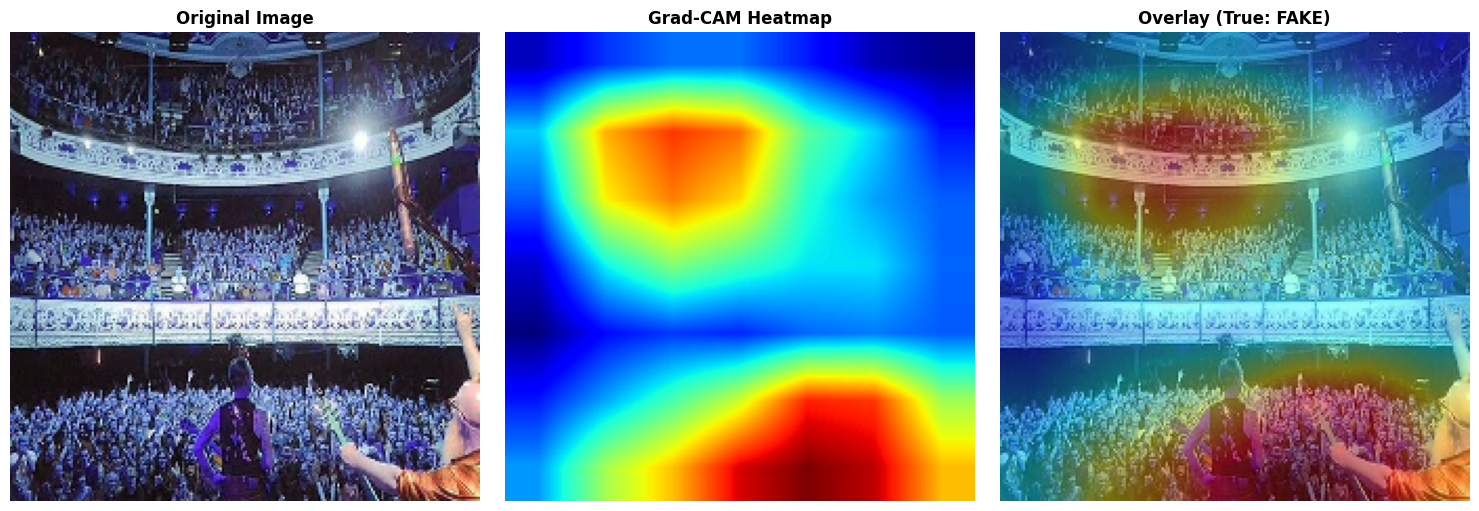


✓ Grad-CAM visualization complete!

Note: SHAP analysis skipped due to BERT loading during prediction.
The Grad-CAM heatmap shows which image regions the model focuses on.


In [31]:
# Simple test: Just run Grad-CAM first (skip SHAP to avoid BERT loading issues during prediction)
print("Testing Grad-CAM visualization only...")
print("="*70)
print(f"Sample {sample_idx}")
print(f"True Label: {sample_label}")
print(f"Text: {sample_text[:100]}...")
print("="*70)

# Initialize GradCAM
gradcam = GradCAM(model_resnet50, backbone='resnet50')

# Compute heatmap
print("\n🔍 Computing Grad-CAM heatmap...")
heatmap = gradcam.compute_heatmap(
    sample_input_ids,
    sample_input_mask, 
    sample_segment_ids,
    sample_image
)

# Create overlay
overlay = gradcam.overlay_heatmap(sample_image, heatmap, alpha=0.4)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
img_display = np.transpose(sample_image, (1, 2, 0))
if img_display.max() <= 1.0:
    img_display = (img_display * 255).astype(np.uint8)
axes[0].imshow(img_display.astype(np.uint8))
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Heatmap
axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
axes[1].axis('off')

# Overlay
axes[2].imshow(overlay)
axes[2].set_title(f'Overlay (True: {sample_label})', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Grad-CAM visualization complete!")
print("\nNote: SHAP analysis skipped due to BERT loading during prediction.")
print("The Grad-CAM heatmap shows which image regions the model focuses on.")

In [ ]:
# Better approach: Create a new GradCAM instance that rebuilds the conv_base properly
print("Creating enhanced GradCAM with proper gradient flow...")
print("="*70)

# This will rebuild ResNet50 without pooling to enable gradient flow
gradcam_enhanced = GradCAM(model_resnet50, backbone='resnet50')

print("\nTesting enhanced Grad-CAM...")
heatmap = gradcam_enhanced.compute_heatmap(
    sample_input_ids,
    sample_input_mask,
    sample_segment_ids,
    sample_image
)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original image
img_display = np.transpose(sample_image, (1, 2, 0))
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
axes[0].imshow(img_display)
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Heatmap
axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title('Enhanced Grad-CAM Heatmap', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Overlay
overlayed = gradcam_enhanced.overlay_heatmap(sample_image, heatmap, alpha=0.4)
axes[2].imshow(overlayed)
axes[2].set_title(f'Overlay (True: {sample_label})', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Enhanced Grad-CAM complete!")

In [ ]:
# Fix TensorFlow Hub cache issue
import shutil
import tempfile

# Clear TF Hub cache
tfhub_cache = os.path.join(tempfile.gettempdir(), 'tfhub_modules')
corrupted_module = os.path.join(tfhub_cache, '5a395eafef2a37bd9fc55d7f6ae676d2a134a838')

if os.path.exists(corrupted_module):
    print(f"Removing corrupted TF Hub cache: {corrupted_module}")
    shutil.rmtree(corrupted_module)
    print("✓ Cache cleared")
    print("\nNow rebuilding the model to re-download BERT...")
    
    # Rebuild model to trigger BERT download
    tf.keras.backend.clear_session()
    gc.collect()
    
    with strategy.scope():
        model_resnet50 = get_news_model_resnet50(params_final)
        model_resnet50.optimizer.learning_rate.assign(0.0005)
        model_resnet50.load_weights(weights_file)
    
    print("✓ Model rebuilt with fresh BERT download")
else:
    print(f"Cache directory not found at: {corrupted_module}")
    print("The issue may be different. Trying to rebuild model anyway...")
    
    # Rebuild model
    tf.keras.backend.clear_session()
    gc.collect()
    
    with strategy.scope():
        model_resnet50 = get_news_model_resnet50(params_final)
        model_resnet50.optimizer.learning_rate.assign(0.0005)
        model_resnet50.load_weights(weights_file)
    
    print("✓ Model rebuilt")

### 11.5 Batch Explanation Analysis

Analyze explanations across multiple samples to understand model behavior.

In [ ]:
def analyze_multiple_samples(
    model,
    indices,
    test_data,
    backbone='resnet50',
    save_dir='explanations'
):
    """
    Generate Grad-CAM visualizations for multiple samples.
    
    Args:
        model: Trained model
        indices: List of sample indices to analyze
        test_data: Dict with keys: 'texts', 'images', 'input_ids', 'input_masks', 'segment_ids', 'labels'
        backbone: 'resnet50' or 'vgg19'
        save_dir: Directory to save visualizations
    
    Returns:
        results: List of dicts with predictions and heatmaps
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    gradcam = GradCAM(model, backbone=backbone)
    results = []
    
    print(f"Analyzing {len(indices)} samples...")
    
    for i, idx in enumerate(tqdm(indices, desc="Generating explanations")):
        text = test_data['texts'][idx]
        image = test_data['images'][idx]
        input_ids = test_data['input_ids'][idx]
        input_mask = test_data['input_masks'][idx]
        segment_ids = test_data['segment_ids'][idx]
        true_label = "REAL" if test_data['labels'][idx] == 1 else "FAKE"
        
        # Get prediction
        pred = model.predict(
            [np.expand_dims(input_ids, 0),
             np.expand_dims(input_mask, 0),
             np.expand_dims(segment_ids, 0),
             np.expand_dims(image, 0)],
            verbose=0
        )[0, 0]
        pred_label = "REAL" if pred >= 0.5 else "FAKE"
        
        # Compute Grad-CAM
        heatmap = gradcam.compute_heatmap(
            input_ids, input_mask, segment_ids, image
        )
        overlay = gradcam.overlay_heatmap(image, heatmap, alpha=0.4)
        
        # Save visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original
        img_display = np.transpose(image, (1, 2, 0)) if image.shape[0] == 3 else image
        if img_display.max() <= 1.0:
            img_display = (img_display * 255).astype(np.uint8)
        axes[0].imshow(img_display.astype(np.uint8))
        axes[0].set_title('Original', fontsize=12)
        axes[0].axis('off')
        
        # Heatmap
        axes[1].imshow(heatmap, cmap='jet')
        axes[1].set_title('Grad-CAM', fontsize=12)
        axes[1].axis('off')
        
        # Overlay
        axes[2].imshow(overlay)
        axes[2].set_title(f'Pred: {pred_label} ({pred:.3f})', fontsize=12)
        axes[2].axis('off')
        
        plt.suptitle(f'Sample {idx} | True: {true_label}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{save_dir}/sample_{idx:04d}.png', dpi=150, bbox_inches='tight')
        plt.close()
        
        results.append({
            'index': idx,
            'text': text,
            'true_label': true_label,
            'pred_label': pred_label,
            'prediction': pred,
            'correct': pred_label == true_label,
            'heatmap': heatmap,
            'overlay': overlay
        })
    
    print(f"✓ Saved {len(indices)} explanations to '{save_dir}/'")
    
    # Summary statistics
    correct = sum([r['correct'] for r in results])
    accuracy = correct / len(results)
    print(f"\nAccuracy on analyzed samples: {accuracy:.2%} ({correct}/{len(results)})")
    
    return results

print("✓ Batch analysis function defined")

In [ ]:
# Analyze first 10 test samples
test_data_dict = {
    'texts': test_text,
    'images': test_imagesX,
    'input_ids': test_input_ids,
    'input_masks': test_input_masks,
    'segment_ids': test_segment_ids,
    'labels': testY
}

# Select samples to analyze (first 10)
sample_indices = list(range(10))

batch_results = analyze_multiple_samples(
    model=model_resnet50,
    indices=sample_indices,
    test_data=test_data_dict,
    backbone='resnet50',
    save_dir='gradcam_explanations'
)

### 11.6 Compare Correct vs Incorrect Predictions

Analyze where the model focuses attention for correct vs incorrect predictions.

In [ ]:
# Separate correct and incorrect predictions
correct_samples = [r for r in batch_results if r['correct']]
incorrect_samples = [r for r in batch_results if not r['correct']]

print(f"Correct predictions: {len(correct_samples)}")
print(f"Incorrect predictions: {len(incorrect_samples)}")

# Display comparison
if len(incorrect_samples) > 0:
    print("\n" + "="*70)
    print("INCORRECT PREDICTIONS - Model Mistakes")
    print("="*70)
    for r in incorrect_samples:
        print(f"\nSample {r['index']}:")
        print(f"  True: {r['true_label']}, Predicted: {r['pred_label']} ({r['prediction']:.4f})")
        print(f"  Text: {r['text'][:100]}...")
else:
    print("\n✓ All analyzed samples predicted correctly!")

# Visualize heatmap statistics
if len(batch_results) > 0:
    # Calculate average heatmap intensity
    avg_intensities = [np.mean(r['heatmap']) for r in batch_results]
    max_intensities = [np.max(r['heatmap']) for r in batch_results]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Average intensity distribution
    axes[0].hist(avg_intensities, bins=20, edgecolor='black', alpha=0.7)
    axes[0].set_title('Distribution of Average Heatmap Intensity', fontweight='bold')
    axes[0].set_xlabel('Average Intensity')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)
    
    # Max intensity distribution
    axes[1].hist(max_intensities, bins=20, edgecolor='black', alpha=0.7, color='orange')
    axes[1].set_title('Distribution of Max Heatmap Intensity', fontweight='bold')
    axes[1].set_xlabel('Max Intensity')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nHeatmap Statistics:")
    print(f"  Mean avg intensity: {np.mean(avg_intensities):.4f}")
    print(f"  Mean max intensity: {np.mean(max_intensities):.4f}")

### 11.7 Export Explanations to CSV

Save explanation metadata for further analysis.

In [ ]:
# Create explanation summary DataFrame
explanation_df = pd.DataFrame([
    {
        'sample_index': r['index'],
        'true_label': r['true_label'],
        'predicted_label': r['pred_label'],
        'prediction_score': r['prediction'],
        'correct': r['correct'],
        'text_preview': r['text'][:100],
        'heatmap_mean_intensity': np.mean(r['heatmap']),
        'heatmap_max_intensity': np.max(r['heatmap']),
        'heatmap_std': np.std(r['heatmap']),
        'visualization_path': f"gradcam_explanations/sample_{r['index']:04d}.png"
    }
    for r in batch_results
])

# Save to CSV
explanation_df.to_csv('explanation_analysis.csv', index=False)
print("✓ Explanation metadata saved to 'explanation_analysis.csv'")

# Display summary
print("\n" + "="*70)
print("EXPLANATION SUMMARY")
print("="*70)
print(explanation_df[['sample_index', 'true_label', 'predicted_label', 
                       'prediction_score', 'correct']].to_string(index=False))
print("="*70)

---

## Summary: Explainability Implementation ✅

### What We Added:

1. **GradCAM Class** 
   - Works with both ResNet50 and VGG19
   - Auto-detects target conv layer (`conv5_block3_out` or `block5_conv4`)
   - Computes gradient-weighted heatmaps
   - Overlays heatmaps on original images

2. **SHAPTextExplainer Class**
   - Attributes predictions to text tokens
   - Holds image fixed to isolate text contributions
   - Uses SHAP with text masking
   - Generates interactive visualizations

3. **Unified Interface**
   - `explain_prediction()`: Single-sample explanation with both Grad-CAM + SHAP
   - `analyze_multiple_samples()`: Batch processing with automatic saving
   - Export to CSV for further analysis

### Usage:

```python
# Single sample
explain_prediction(
    model=model_resnet50,
    text="Your text here",
    image=image_array,
    input_ids=...,
    backbone='resnet50',
    show_gradcam=True,
    show_shap=True
)

# Batch analysis
results = analyze_multiple_samples(
    model=model_resnet50,
    indices=[0, 1, 2, ...],
    test_data=test_data_dict,
    backbone='resnet50'
)
```

### Files Generated:
- `gradcam_explanations/sample_XXXX.png`: Visualization for each sample
- `explanation_analysis.csv`: Metadata and statistics

### Next Steps for CLIP + Cross-Attention:
Ready to implement when you are! 🚀